# Advanced Lane Finding
In order to manipulate a car I need to measure how much my lane is curving. To do that I need to map out the lanes in my camera image.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def arrange_side_by_side(img1, img2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30))
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    plt.show()

## Compute the Camera Calibration and Distortion Coefficients
Camera image has distortions. This means camera image does not represent perfectly real world objects. There is two types of distortion, Radial Distortion and Tangental Distortion.

To get a curvature of lane lines based on real world I need to correct those distortions, before I map out the lane lines from a camera image,.

To correct distortions I need to calculate some parameters.
 - distortion coefficients (k1, k2, p1, p2, k3)
 - camera matrix ([[fx, 0, xc], [0, fy, yc], [0, 0, 1]]) <= intrinsic parameters
 - extrinsic parameters (rotation and translation vector)
 
To find those parameters I'll do calibration through chessboard images.
 1. detect image points on 2D chessboard image space using findChessboardCorners() function
 2. prepare object points on 3D real world space which indicate same points with 1st step.
 3. get parameters for correcting image distortion using calibrateCamera() function.
 4. finally correct distortions using undistort() function.

In [ ]:
fname = 'camera_cal/calibration2.jpg'
img = mpimg.imread(fname)

img_origin = np.copy(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray, cmap='gray')

In [ ]:
# 1st step: find image points on 2D chessboard image
pattern_size = (9, 6)
found, image_points_base = cv2.findChessboardCorners(img_gray, pattern_size, None)

# checking
cv2.drawChessboardCorners(img, pattern_size, image_points_base, found)
arrange_side_by_side(img_origin, img, 'original image', 'draw corners')

In [ ]:
# 2nd step: prepare object points
object_points_base = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
object_points_base[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape((-1, 2))

# x = np.arange(pattern_size[0])
# y = np.arange(pattern_size[1])
# xx, yy = np.meshgrid(x,y)
# object_points_base = [[xx[i][j], yy[i][j], 0] for j in range(pattern_size[0]) for i in range(pattern_size[1])]

object_points = []
image_points = []

if found:
    object_points.append(object_points_base)
    image_points.append(image_points_base)

In [ ]:
# 3rd step: calibrate camera to get parameters for undistortion
try:
    r, cam_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img.shape[1::-1], None, None)
except:
    print('Exception occured at calibrateCamera function!!\nPlease check the parameters.')

In [ ]:
# 4th step: Undistortion
undist_img = cv2.undistort(img_origin, cam_mtx, dist_coeff)

In [ ]:
# See the result
arrange_side_by_side(img_origin, undist_img, 'original', 'undistorted')

## Create Thresholded Binary Image

In [1]:
def filter_sobel(img, orientation='x'):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    elif orientation == 'y':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
    else:
        print("Unknown value of orientation.")
        return None
    abs_img = np.absolute(sobel)
    return abs_img * 255 / np.max(abs_img)

def filter_sobel_gradient_magnitude(img, ksize=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    return grad_mag * 255 / np.max(grad_mag)

def filter_gradient_direction(img, ksize=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize))
    abs_sobely = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize))
    return np.arctan2(abs_sobely, abs_sobelx)
    
def filter_hls(rgb_img, channel='s'):
    if channel == 'h':
        c = 0
    elif channel == 'l':
        c = 1
    elif channel == 's':
        c = 2
    else:
        print("Undefined parameter channel")
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    return hls[:,:,c]

def create_binary_image(img, thresh_min=50, thresh_max=100):
    binary = np.zeros_like(img)
    binary[(img > thresh_min) & (img < thresh_max)] = 1
    return binary

In [ ]:
rimg = mpimg.imread('test_images/straight_lines1.jpg')

In [ ]:
# apply the Sobel filter for y direction
#sobelx = filter_sobel(rimg, 'x')
#binary_sobelx = create_binary_image(sobelx, 15, 140)
#
#arrange_side_by_side(rimg, binary_sobelx, 'Origin', 'BinaryX')

In [ ]:
# apply the Sobel filter for y direction
#sobely = filter_sobel(rimg, 'y')
#binary_sobely = create_binary_image(sobely, 20, 150)
#
#arrange_side_by_side(rimg, binary_sobely, 'Origin', 'Binary')

In [ ]:
grad_mag = filter_sobel_gradient_magnitude(rimg, ksize=5)
binary_grad_mag = create_binary_image(grad_mag, 30, 170)

arrange_side_by_side(rimg, binary_grad_mag, 'Origin', 'Gradient Magnitude Thresh')

In [ ]:
grad_dir = filter_gradient_direction(rimg, ksize=11)
binary_grad_dir = create_binary_image(grad_dir, 0.8, 1.3)

arrange_side_by_side(rimg, binary_grad_dir, 'Origin', 'Gradient Direction')

In [ ]:
s_img = filter_hls(rimg, 's')
binary_satulate = create_binary_image(s_img, 150, 300)
arrange_side_by_side(rimg, binary_satulate, 'Origin', 'Satulate Channel')

In [ ]:
# Combine the above binary images
binary = np.zeros_like(binary_grad_dir)
binary[((binary_grad_mag == 1) & (binary_grad_dir == 1) | (binary_satulate == 1))] = 1

arrange_side_by_side(rimg, binary, 'Origin', 'Combined Binary Image')

## Apply Perspective Transform

In [ ]:
#%matplotlib qt
%matplotlib inline

src = np.float32(
    [[840, 546],
     [1051, 677],
     [244, 686],
     [453, 546]])
dst = np.float32(
    [[1051, 463],
     [1051, 686],
     [245, 686],
     [245, 463]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [ ]:
warped = cv2.warpPerspective(binary, M, (rimg.shape[1], rimg.shape[0]), flags=cv2.INTER_LINEAR)

arrange_side_by_side(rimg, warped, 'Original', 'Bird Eyes View')

## Sliding Windows to plot lines

In [2]:
def get_starting_point_likely(img):
    hist = np.sum(img[img.shape[0]//2:, :], axis=0)
    center_horizontal = img.shape[1]//2
    left = np.argmax(hist[:center_horizontal])
    right = np.argmax(hist[center_horizontal:]) + center_horizontal
    return left, right

def search_lane_line_pixels(img, left_start, right_start, draw_rect=False):
    margin = 100
    n_window = 9
    minpix_thresh = 50
    
    nonzero = img.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])

    # output place holders
    left_lane_pixels = []
    right_lane_pixels = []
    out_img = np.dstack((img, img, img)) * 255
    
    for i in range(n_window):
        bottom = img.shape[0] - img.shape[0]//n_window * i
        top = bottom - img.shape[0]//n_window
        l_left = left_start - margin
        l_right = left_start + margin
        r_left = right_start - margin
        r_right = right_start + margin
        
        if draw_rect:
            cv2.rectangle(out_img, (l_left, top), (l_right, bottom), (0,255,0), 2)
            cv2.rectangle(out_img, (r_left, top), (r_right, bottom), (0,255,0), 2)
        
        left_inds = ((nonzero_y > top) & (nonzero_y < bottom) & (nonzero_x > l_left) & (nonzero_x < l_right)).nonzero()[0]
        right_inds = ((nonzero_y > top) & (nonzero_y < bottom) & (nonzero_x > r_left) & (nonzero_x < r_right)).nonzero()[0]
        left_lane_pixels.append(left_inds)
        right_lane_pixels.append(right_inds)
        
        if len(left_inds > minpix_thresh):
            left_start = np.int(np.mean(nonzero_x[left_inds]))
        if len(right_inds > minpix_thresh):
            right_start = np.int(np.mean(nonzero_x[right_inds]))
            
    try:
        left_lane_pixels = np.concatenate(left_lane_pixels)
        right_lane_pixels = np.concatenate(right_lane_pixels)
    except ValueError:
        pass
    
    lx = nonzero_x[left_lane_pixels]
    ly = nonzero_y[left_lane_pixels]
    rx = nonzero_x[right_lane_pixels]
    ry = nonzero_y[right_lane_pixels]
    
    out_img[ly, lx] = [255, 0, 0]
    out_img[ry, rx] = [0, 0, 255]
    
    return lx, ly, rx, ry ,out_img

In [3]:
def get_quadratic_plots(img, quad_coef):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        plotx = quad_coef[0]*ploty**2 + quad_coef[1]*ploty + quad_coef[2]
    except TypeError:
        plotx = 1*ploty**2 + 1*ploty
    return ploty, plotx

In [ ]:
# Blind search execution
starting_point_l, starting_point_r = get_starting_point_likely(warped)
lx, ly, rx, ry, rect_drawed = search_lane_line_pixels(warped, starting_point_l, starting_point_r, True)

coeff_left = np.polyfit(ly, lx, 2)
coeff_right = np.polyfit(ry, rx, 2)
ploty, plotx_l = get_quadratic_plots(warped, coeff_left)
ploty, plotx_r = get_quadratic_plots(warped, coeff_right)

plt.imshow(rect_drawed)
plt.plot(plotx_l, ploty, color='yellow')
plt.plot(plotx_r, ploty, color='yellow')
plt.xlim(0, rect_drawed.shape[1])
plt.ylim(rect_drawed.shape[0], 0)

## Use the previous polynomial to skip the sliding window
So far I did the blind search. However using the full alforithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

Instead I can just search in a margin around the previous lane line position. So, once I know where the lines are in one frame of video I can do a highly targeted search for them in the next frame.

And this way should help me track the lanes through sharp curves and tricky conditions. If I lose track of the lines, go back to my sliding windos search or other method to rediscover them.

To hold the pixel values contained within the boundaries of a given sliding window I used the variables called <code>left_lane_pixels</code> and <code>right_lane_pixels</code>. This time, we'll take the polynomial functions I fit before, along with a hyperparameter <code>margin</code>, to determine whivh activated pixcels fall into the green shaded areas from the avobe image.

To implement this, I'll want to grab only those pixels with x values that are +/- my margin from my polynomial lines.

In [4]:
def get_search_area_idx(prev_binary, prev_coefs, margin=100):
    idx_nonzero = prev_binary.nonzero()
    idx_nonzero_y = np.array(idx_nonzero[0])
    idx_nonzero_x = np.array(idx_nonzero[1])
    prev_polynomial = prev_coefs[0] * idx_nonzero_y**2 + prev_coefs[1] * idx_nonzero_y + prev_coefs[2]
    is_target = (prev_polynomial-margin < idx_nonzero_x) & (prev_polynomial+margin > idx_nonzero_x)
    idx_nonzero_y = idx_nonzero_y[is_target]
    idx_nonzero_x = idx_nonzero_x[is_target]
    return idx_nonzero_y, idx_nonzero_x


In [5]:
def get_quadratic_coefficient(binary_image, ym_per_pix, xm_per_pix):
    nonzero = np.nonzero(binary_image)
    nonzero_y = nonzero[0]
    nonzero_x = nonzero[1]
    return np.polyfit(nonzero_y* ym_per_pix, nonzero_x*xm_per_pix, 2)

def search_polynomial_around_prior(new_binary_image, target_y, target_x, ym_per_pix=1, xm_per_pix=1):
    new_image = np.zeros_like(new_binary_image)
    new_image[target_y, target_x] = 1
    coefficient = get_quadratic_coefficient(new_image, ym_per_pix, xm_per_pix)
    return coefficient

In [ ]:
target_ly, target_lx = get_search_area_idx(warped, coeff_left, 80)
target_ry, target_rx = get_search_area_idx(warped, coeff_right, 80)

In [ ]:
new_image = np.copy(warped)
coeff_left = search_polynomial_around_prior(new_image, target_ly, target_lx)
coeff_right = search_polynomial_around_prior(new_image, target_ry, target_rx)

In [ ]:
ploty, plotx_l = get_quadratic_plots(warped, coeff_left)
ploty, plotx_r = get_quadratic_plots(warped, coeff_right)

plt.imshow(new_image, cmap='gray')
plt.plot(plotx_l, ploty, color='red')
plt.plot(plotx_r, ploty, color='red')
plt.show()

## Measuring Curvature
Next I'll compute the radius of curvature of a polinomial. I'm fitting for f(y), rather than f(x), because the lane lines in the warped image are near vartical and may have the same x value for more than one y value.

### Radius of Curvature
The radius of curvature at any point x of the function x=f(y) is given as follows:

    f(y) = Ay**2 + By + C = x
    Rcurve = [1+(dx/dy)**2]**3/2 / |d**2x/dy**2|
    
In the case of the second order polynomial above, the first and second derivatives are:

    f'(y) = dx/dy = 2Ay + B
    f"(y) = d**2x/dy**2 = 2A
   
So, our equation for radius of curvature becomes:
    
    Rcurve = (1+(2Ay+B)**2)**3/2 / |2A|
    
The y values of my image increase from top to bottom, so if, for example, I wanted to measure the radius of curvature closest to my vehicle, I could evaluate the formula above at the y value corresponding to the bottom of my image, or in Python, at yvalue = image.shape[0].

In [6]:
def measure_curvature(coeff, ploty, ymeters_per_pix=1):
    y_eval = np.max(ploty)*ymeters_per_pix
    d1_poly = 2*coeff[0]*y_eval + coeff[1]
    d2_poly = 2*coeff[0]
    return (1+(d1_poly**2))**1.5 / np.absolute(d2_poly)

In [ ]:
left_curve = measure_curvature(coeff_left, ploty)
right_curve = measure_curvature(coeff_right, ploty)

## Measureing Physical Lane Curvature
#### Measureing How long and wide the section of lane
We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, I can assume that if I'm projecting a section of lane similar to the images above, the lane is about 30 meaters long and 3.7 meters wide.

Let's say that our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed), and we'll say roughly 700 relevant pixels in the x-dimension (if from 200 pixels on the left to 900 on the right, or 700). Therefore, to convert from pixels to real-world meter measurements, I can use(in this case):

    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

In [ ]:
ym_per_pix = 30/warped.shape[0]
xm_per_pix = 3.7/ (starting_point_r - starting_point_l)
real_coeff_left = search_polynomial_around_prior(new_image, target_ly, target_lx, ym_per_pix, xm_per_pix)
real_coeff_right = search_polynomial_around_prior(new_image, target_ry, target_rx, ym_per_pix, xm_per_pix)

In [ ]:
left_curve = measure_curvature(real_coeff_left, ploty, ym_per_pix)
right_curve = measure_curvature(real_coeff_right,  ploty, ym_per_pix)

In [ ]:
print(left_curve, 'm', right_curve, 'm')

#### Vehicle position with respect to center of the road

In [7]:
def measure_difference_from_center(image_width, coeff_l, coeff_r, xm_per_pix):
    difference = (image_width - coeff_r[2]) - coeff_l[2]
    if difference > 0:
        result_msg = "Vehicle is {}m right of center".format(np.round(difference*xm_per_pix, 2))
    elif difference < 0:
        result_msg = "Vehicle is {}m left of center".format(np.round(-difference*xm_per_pix, 2))
    else:
        result_msg = "Vehicle is Just Center!!"
    return difference, result_msg

In [ ]:
difference, msg = measure_difference_from_center(warped.shape[1], coeff_left, coeff_right)
print(difference, msg)

In [8]:
def draw_lane_area(image, plotx_left, plotx_right, color=[0,255,0]):
    canvas = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    mgrid = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    is_lane_area =[]
    for i, row in enumerate(mgrid[1]):
        is_lane = (row > plotx_left[i]) & (row < plotx_right[i])
        is_lane_area.append(is_lane)
    canvas[is_lane_area] = color
    return canvas

In [9]:
def color_lane_lines(binary_img, ly, lx, ry, yx, l_color=[255,0,0], r_color=[0,0,255]):
    out_img = np.dstack((binary_img, binary_img, binary_img))
    out_img[ly, lx] = l_color
    out_img[ry, yx] = r_color
    return out_img.astype('uint8')

In [ ]:
area_colored_img = draw_lane_area(warped, plotx_left, plotx_right)
line_colored_img = color_lane_lines(warped, target_ly, target_lx, target_ry, target_rx)
combined = area_colored_img + line_colored_img
unwarped = cv2.warpPerspective(combined, Minv, (rimg.shape[1], rimg.shape[0]), flags=cv2.INTER_LINEAR)

In [ ]:
plt.imshow(unwarped)

In [10]:
def draw_mask(initial_img, mask_img, α=0.8, β=0.8, γ=0.):
    return cv2.addWeighted(initial_img, α, mask_img, β, γ)

In [ ]:
masked_lane_area = draw_mask(unwarped, rimg)

In [ ]:
text1 = "Radius of Curvature = {}(m)".format(np.round(left_curve, -1))
text2 = "Vehicle is {}".format(diff_result)
masked_lane_area = cv2.putText(masked_lane_area, text1, (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
masked_lane_area = cv2.putText(masked_lane_area, text2, (30, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)

In [ ]:
plt.imshow(masked_lane_area)

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from calibrate import Calibration
from input_holder import InputHolder

In [32]:
def to_binary(image):
    grad_mag = filter_sobel_gradient_magnitude(image, ksize=5)
    grad_dir = filter_gradient_direction(image, ksize=11)
    saturate = filter_hls(image, 's')
    
    binary_grad_mag = create_binary_image(grad_mag, 30, 170)
    binary_grad_dir = create_binary_image(grad_dir, 0.8, 1.3)
    binary_satulate = create_binary_image(saturate, 150, 300)
    
    binary = np.zeros_like(binary_grad_dir)
    binary[((binary_grad_mag == 1) & (binary_grad_dir == 1) | (binary_satulate == 1))] = 1
    return binary
    
def add_weighted_sequential_coefficient(current_coeffs, prev_coeffs, prev_weight=0.0):
    norm_a = prev_coeffs[0]*prev_weight + current_coeffs[0]*(1-prev_weight)   
    norm_b = prev_coeffs[1]*prev_weight + current_coeffs[1]*(1-prev_weight)
    norm_c = prev_coeffs[2]*prev_weight + current_coeffs[2]*(1-prev_weight)
    return [norm_a, norm_b, norm_c]

def process_image(image, holder):
    global is_first_frame
    global starting_point_l
    global starting_point_r
    global prev_coeff_left
    global prev_coeff_right
    
    undist_img = cv2.undistort(image, holder.calib.cam_mtx, holder.calib.dist_coeff)
    binary_img = to_binary(undist_img)
    warped_img = cv2.warpPerspective(binary_img, holder.M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    if is_first_frame:
        is_first_frame = False
        starting_point_l, starting_point_r = get_starting_point_likely(warped_img) 
        lx_pixels, ly_pixels, rx_pixels, ry_pixels, lane_colored_img = search_lane_line_pixels(warped_img, starting_point_l, starting_point_r)
        coeff_left = np.polyfit(ly_pixels, lx_pixels, 2)
        coeff_right = np.polyfit(ry_pixels, rx_pixels, 2)
    else:
        ly_pixels, lx_pixels = get_search_area_idx(warped_img, prev_coeff_left, 80)
        ry_pixels, rx_pixels = get_search_area_idx(warped_img, prev_coeff_right, 80)
        coeff_left = search_polynomial_around_prior(image, ly_pixels, lx_pixels)
        coeff_right = search_polynomial_around_prior(image, ry_pixels, rx_pixels)
    
    coeff_left = add_weighted_sequential_coefficient(coeff_left, prev_coeff_left, 0.9)
    coeff_right = add_weighted_sequential_coefficient(coeff_right, prev_coeff_right, 0.9)
    ploty, plotx_l = get_quadratic_plots(warped_img, coeff_left)
    ploty, plotx_r = get_quadratic_plots(warped_img, coeff_right)
    left_curve = measure_curvature(coeff_left, ploty)
    right_curve = measure_curvature(coeff_right, ploty)
    
    # draw lane mask (lane area & lane line)
    area_colored_img = draw_lane_area(warped_img, plotx_l, plotx_r)
    line_colored_img = color_lane_lines(warped_img, ly_pixels, lx_pixels, ry_pixels, rx_pixels)
    combined = area_colored_img + line_colored_img
    unwarped = cv2.warpPerspective(combined, holder.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    masked_lane_area = draw_mask(unwarped, image)
    
    prev_coeff_avg = coeff_avg
    prev_coeff_left = coeff_left
    prev_coeff_right = coeff_right
    
    # get curvature
    ym_per_pix = holder.real_ym/warped_img.shape[0]
    xm_per_pix = holder.real_xm/ (starting_point_r - starting_point_l)
    real_coeff_left = search_polynomial_around_prior(image, ly_pixels, lx_pixels, ym_per_pix, xm_per_pix)
    real_coeff_right = search_polynomial_around_prior(image, ry_pixels, rx_pixels, ym_per_pix, xm_per_pix)
    real_left_curve = measure_curvature(real_coeff_left, ploty, ym_per_pix)
    real_right_curve = measure_curvature(real_coeff_right,  ploty, ym_per_pix)
    
    _, msg = measure_difference_from_center(warped_img.shape[1], coeff_left, coeff_right, xm_per_pix)
    text1 = "Radius of Curvature = {}(m)".format(np.round(left_curve, -1))
    text2 = "Vehicle is {}".format(msg)
    masked_lane_area = cv2.putText(masked_lane_area, text1, (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    masked_lane_area = cv2.putText(masked_lane_area, text2, (30, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)    
    return masked_lane_area

In [20]:
# camera calibration
fnames = glob.glob('camera_cal/*.jpg')
pattern_size = (9, 6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calib = Calibration(fnames, pattern_size, criteria)

In [14]:
# Static values
src = np.float32(
    [[840, 546],
     [1051, 677],
     [244, 686],
     [453, 546]])
dst = np.float32(
    [[1051, 463],
     [1051, 686],
     [245, 686],
     [245, 463]])
holder = InputHolder(calib, src, dst)

In [15]:
def normalize_coefficient(coeff_l, coeff_r, lx, rx):
    weight_l = len(lx) / (len(lx) + len(rx))
    weight_r = len(rx) / (len(lx) + len(rx))
    return coeff_l * weight_l + coeff_r * weight_r

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


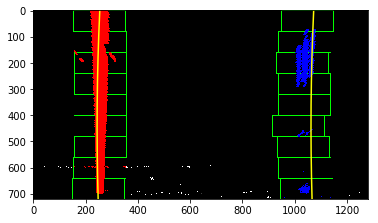

In [33]:
# For Initialize
rimg = mpimg.imread('test_images/straight_lines1.jpg')
undist_img = cv2.undistort(rimg, holder.calib.cam_mtx, holder.calib.dist_coeff)
binary_img = to_binary(undist_img)
warped_img = cv2.warpPerspective(binary_img, holder.M, (rimg.shape[1], rimg.shape[0]), flags=cv2.INTER_LINEAR)
    
starting_point_l, starting_point_r = get_starting_point_likely(warped_img)
lx, ly, rx, ry, rect_drawed = search_lane_line_pixels(warped_img, starting_point_l, starting_point_r, True)
coeff_left = np.polyfit(ly, lx, 2)
coeff_right = np.polyfit(ry, rx, 2)
    
coeff_avg = normalize_coefficient(coeff_left, coeff_right, lx, rx)
coeff_left[0:2] = coeff_avg[0:2]
coeff_right[0:2] = coeff_avg[0:2]

ploty, plotx_l = get_quadratic_plots(warped_img, coeff_left)
ploty, plotx_r = get_quadratic_plots(warped_img, coeff_right)
plt.imshow(rect_drawed)
plt.plot(plotx_l, ploty, color='yellow')
plt.plot(plotx_r, ploty, color='yellow')

In [34]:
# Changable values
is_first_frame = True
starting_point_l = 0
starting_point_r = 0
prev_coeff_avg = coeff_avg
prev_coeff_left = coeff_left
prev_coeff_right = coeff_right

In [35]:
test_video = 'output_images/lane_drawed_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
binary_clip = clip.fl_image(lambda image: process_image(image, holder))
%time binary_clip.write_videofile(test_video, audio=False)

[MoviePy] >>>> Building video output_images/lane_drawed_project_video.mp4
[MoviePy] Writing video output_images/lane_drawed_project_video.mp4





  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]


  0%|                                                                                 | 1/1261 [00:00<05:53,  3.57it/s]


  0%|▏                                                                                | 2/1261 [00:00<05:51,  3.58it/s]


  0%|▏                                                                                | 3/1261 [00:00<05:58,  3.51it/s]


  0%|▎                                                                                | 4/1261 [00:01<06:19,  3.31it/s]


  0%|▎                                                                                | 5/1261 [00:01<06:08,  3.41it/s]


  0%|▍                                                                                | 6/1261 [00:01<06:10,  3.38it/s]


  1%|▍                                                                                | 7/1261 [00:02<06:16,  3.33it/s]


  1%|▌               

  5%|████▎                                                                           | 67/1261 [00:19<05:44,  3.47it/s]


  5%|████▎                                                                           | 68/1261 [00:19<05:45,  3.45it/s]


  5%|████▍                                                                           | 69/1261 [00:20<05:45,  3.45it/s]


  6%|████▍                                                                           | 70/1261 [00:20<05:44,  3.45it/s]


  6%|████▌                                                                           | 71/1261 [00:20<05:48,  3.42it/s]


  6%|████▌                                                                           | 72/1261 [00:20<06:00,  3.30it/s]


  6%|████▋                                                                           | 73/1261 [00:21<05:58,  3.31it/s]


  6%|████▋                                                                           | 74/1261 [00:21<05:44,  3.45it/s]


  6%|████▊              

 11%|████████▍                                                                      | 134/1261 [00:38<05:39,  3.32it/s]


 11%|████████▍                                                                      | 135/1261 [00:39<05:27,  3.44it/s]


 11%|████████▌                                                                      | 136/1261 [00:39<05:23,  3.48it/s]


 11%|████████▌                                                                      | 137/1261 [00:39<05:21,  3.49it/s]


 11%|████████▋                                                                      | 138/1261 [00:39<05:21,  3.50it/s]


 11%|████████▋                                                                      | 139/1261 [00:40<05:20,  3.50it/s]


 11%|████████▊                                                                      | 140/1261 [00:40<05:25,  3.44it/s]


 11%|████████▊                                                                      | 141/1261 [00:40<05:24,  3.45it/s]


 11%|████████▉          

 16%|████████████▌                                                                  | 201/1261 [00:58<05:20,  3.31it/s]


 16%|████████████▋                                                                  | 202/1261 [00:58<05:24,  3.27it/s]


 16%|████████████▋                                                                  | 203/1261 [00:59<05:26,  3.24it/s]


 16%|████████████▊                                                                  | 204/1261 [00:59<05:31,  3.19it/s]


 16%|████████████▊                                                                  | 205/1261 [00:59<05:28,  3.21it/s]


 16%|████████████▉                                                                  | 206/1261 [01:00<05:22,  3.27it/s]


 16%|████████████▉                                                                  | 207/1261 [01:00<05:18,  3.31it/s]


 16%|█████████████                                                                  | 208/1261 [01:00<05:13,  3.36it/s]


 17%|█████████████      

 21%|████████████████▊                                                              | 268/1261 [01:18<04:58,  3.33it/s]


 21%|████████████████▊                                                              | 269/1261 [01:19<04:55,  3.36it/s]


 21%|████████████████▉                                                              | 270/1261 [01:19<04:48,  3.43it/s]


 21%|████████████████▉                                                              | 271/1261 [01:19<04:49,  3.42it/s]


 22%|█████████████████                                                              | 272/1261 [01:19<04:52,  3.39it/s]


 22%|█████████████████                                                              | 273/1261 [01:20<04:51,  3.39it/s]


 22%|█████████████████▏                                                             | 274/1261 [01:20<04:59,  3.30it/s]


 22%|█████████████████▏                                                             | 275/1261 [01:20<04:59,  3.29it/s]


 22%|█████████████████▎ 

 27%|████████████████████▉                                                          | 335/1261 [01:39<04:44,  3.25it/s]


 27%|█████████████████████                                                          | 336/1261 [01:39<04:39,  3.31it/s]


 27%|█████████████████████                                                          | 337/1261 [01:39<04:37,  3.33it/s]


 27%|█████████████████████▏                                                         | 338/1261 [01:39<04:41,  3.28it/s]


 27%|█████████████████████▏                                                         | 339/1261 [01:40<04:40,  3.28it/s]


 27%|█████████████████████▎                                                         | 340/1261 [01:40<04:41,  3.27it/s]


 27%|█████████████████████▎                                                         | 341/1261 [01:40<04:47,  3.20it/s]


 27%|█████████████████████▍                                                         | 342/1261 [01:41<04:37,  3.31it/s]


 27%|███████████████████

 32%|█████████████████████████▏                                                     | 402/1261 [01:59<04:33,  3.14it/s]


 32%|█████████████████████████▏                                                     | 403/1261 [01:59<04:30,  3.17it/s]


 32%|█████████████████████████▎                                                     | 404/1261 [02:00<04:23,  3.26it/s]


 32%|█████████████████████████▎                                                     | 405/1261 [02:00<04:24,  3.24it/s]


 32%|█████████████████████████▍                                                     | 406/1261 [02:00<04:21,  3.27it/s]


 32%|█████████████████████████▍                                                     | 407/1261 [02:00<04:18,  3.30it/s]


 32%|█████████████████████████▌                                                     | 408/1261 [02:01<04:18,  3.30it/s]


 32%|█████████████████████████▌                                                     | 409/1261 [02:01<04:20,  3.28it/s]


 33%|███████████████████

 37%|█████████████████████████████▍                                                 | 469/1261 [02:19<04:07,  3.20it/s]


 37%|█████████████████████████████▍                                                 | 470/1261 [02:20<04:12,  3.13it/s]


 37%|█████████████████████████████▌                                                 | 471/1261 [02:20<04:11,  3.14it/s]


 37%|█████████████████████████████▌                                                 | 472/1261 [02:20<04:21,  3.01it/s]


 38%|█████████████████████████████▋                                                 | 473/1261 [02:21<04:19,  3.04it/s]


 38%|█████████████████████████████▋                                                 | 474/1261 [02:21<04:14,  3.09it/s]


 38%|█████████████████████████████▊                                                 | 475/1261 [02:21<04:09,  3.15it/s]


 38%|█████████████████████████████▊                                                 | 476/1261 [02:22<04:04,  3.21it/s]


 38%|███████████████████

 43%|█████████████████████████████████▌                                             | 536/1261 [02:40<03:46,  3.21it/s]


 43%|█████████████████████████████████▋                                             | 537/1261 [02:41<03:40,  3.28it/s]


 43%|█████████████████████████████████▋                                             | 538/1261 [02:41<03:45,  3.21it/s]


 43%|█████████████████████████████████▊                                             | 539/1261 [02:41<03:39,  3.29it/s]


 43%|█████████████████████████████████▊                                             | 540/1261 [02:41<03:39,  3.28it/s]


 43%|█████████████████████████████████▉                                             | 541/1261 [02:42<03:47,  3.16it/s]


 43%|█████████████████████████████████▉                                             | 542/1261 [02:42<03:45,  3.19it/s]


 43%|██████████████████████████████████                                             | 543/1261 [02:42<03:45,  3.18it/s]


 43%|███████████████████

 48%|█████████████████████████████████████▊                                         | 603/1261 [03:00<03:11,  3.44it/s]


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:00<03:03,  3.57it/s]


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:01<03:06,  3.52it/s]


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:01<03:00,  3.63it/s]


 48%|██████████████████████████████████████                                         | 607/1261 [03:01<03:06,  3.50it/s]


 48%|██████████████████████████████████████                                         | 608/1261 [03:01<03:03,  3.56it/s]


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:02<03:13,  3.37it/s]


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:02<03:12,  3.38it/s]


 48%|███████████████████

 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:20<02:54,  3.39it/s]


 53%|██████████████████████████████████████████                                     | 671/1261 [03:21<02:58,  3.31it/s]


 53%|██████████████████████████████████████████                                     | 672/1261 [03:21<02:56,  3.34it/s]


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:21<03:02,  3.23it/s]


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:22<03:00,  3.25it/s]


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:22<03:00,  3.24it/s]


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:22<03:07,  3.12it/s]


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:23<03:06,  3.13it/s]


 54%|███████████████████

 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:41<02:37,  3.33it/s]


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:41<02:35,  3.37it/s]


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:42<02:33,  3.41it/s]


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:42<02:39,  3.27it/s]


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:42<02:38,  3.28it/s]


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:42<02:36,  3.32it/s]


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:43<02:36,  3.31it/s]


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:43<02:36,  3.30it/s]


 59%|███████████████████

 64%|██████████████████████████████████████████████████▎                            | 804/1261 [04:01<02:15,  3.37it/s]


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [04:01<02:13,  3.42it/s]


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [04:02<02:15,  3.35it/s]


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [04:02<02:16,  3.33it/s]


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [04:02<02:15,  3.35it/s]


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [04:03<02:14,  3.37it/s]


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [04:03<02:13,  3.39it/s]


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [04:03<02:13,  3.38it/s]


 64%|███████████████████

 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:22<02:02,  3.19it/s]


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:22<02:00,  3.22it/s]


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:22<01:58,  3.28it/s]


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:23<01:58,  3.27it/s]


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:23<02:02,  3.16it/s]


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:23<02:00,  3.20it/s]


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:24<01:58,  3.24it/s]


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:24<01:57,  3.25it/s]


 70%|███████████████████

 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:43<01:45,  3.05it/s]


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:43<01:45,  3.05it/s]


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:43<01:44,  3.07it/s]


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:43<01:43,  3.10it/s]


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:44<01:41,  3.15it/s]


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:44<01:41,  3.14it/s]


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:44<01:39,  3.19it/s]


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:45<01:39,  3.18it/s]


 75%|███████████████████

 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:04<01:18,  3.25it/s]


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:04<01:15,  3.37it/s]


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:04<01:14,  3.43it/s]


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:05<01:14,  3.41it/s]


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:05<01:15,  3.33it/s]


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:05<01:17,  3.24it/s]


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:06<01:16,  3.26it/s]


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:06<01:16,  3.27it/s]


 80%|███████████████████

 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:26<00:58,  3.23it/s]


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:26<00:58,  3.24it/s]


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:27<00:58,  3.20it/s]


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:27<00:58,  3.20it/s]


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:27<00:58,  3.16it/s]


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:28<00:58,  3.16it/s]


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:28<00:56,  3.24it/s]


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:28<00:56,  3.24it/s]


 86%|███████████████████

 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:46<00:38,  3.19it/s]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:47<00:36,  3.28it/s]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:47<00:37,  3.23it/s]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:47<00:38,  3.11it/s]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:48<00:37,  3.13it/s]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:48<00:36,  3.23it/s]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:48<00:36,  3.20it/s]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:48<00:35,  3.23it/s]


 91%|███████████████████

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:07<00:16,  3.30it/s]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:07<00:18,  2.95it/s]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:07<00:17,  2.95it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:08<00:17,  3.05it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:08<00:16,  3.13it/s]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:08<00:15,  3.21it/s]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:09<00:15,  3.22it/s]


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:09<00:15,  3.20it/s]


 96%|███████████████████

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/lane_drawed_project_video.mp4 

Wall time: 6min 24s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video))